# Cruise Revenue Management: Synthetic Data Generation

**Author:** Akio Azevedo  
**Project:** Revenue Optimization Through Data-Driven Pricing  
**Purpose:** Apply data analysis and machine learning skills to a real-world business problem

---

## Project Overview

This is a multi-notebook project where I apply the skills I've been learning in Python, statistics, and machine learning to solve a revenue management challenge.

**The Business Problem:**  
Cruise lines must balance maximizing revenue (charging higher prices) with maximizing occupancy (filling the ship). The challenge is finding optimal prices for different cabin types over a 120-day booking window.

**This Notebook (Part 1 of 3):**  
Generate realistic synthetic booking data that will serve as training data for:
- **Notebook 2:** Demand forecasting using machine learning
- **Notebook 3:** Price optimization to maximize revenue

**Why Synthetic Data?**  
Creating realistic data from scratch demonstrates understanding of:
- Business dynamics (how customers respond to pricing)
- Statistical modeling (probability distributions, elasticity)
- Data engineering (building clean datasets for ML)

---

## Dataset Specifications

- **Booking Window:** 120 days before sailing
- **Cabin Categories:** 4 types with different price points
- **Key Features:** Price, time to departure, booking patterns
- **Target Variable:** Daily bookings per cabin type

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Reproducibility: fixed seed ensures same results every run
np.random.seed(42)

print("✓ Libraries loaded")

✓ Libraries loaded


In [2]:
# Directory setup
FIGURES_DIR = "../figures"
DATA_DIR = "../data/processed"
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

print("✓ Directories created")

✓ Directories created


---
## 1. Dataset Structure

Creating the foundation of our dataset with two dimensions:
- **Time dimension:** 120 days before sailing (captures booking timeline)
- **Product dimension:** 4 cabin types (captures customer segmentation)

This panel structure allows us to model how bookings vary both over time and across product types.

In [3]:
# Define sailing date and booking window
SAILING_DATE = pd.to_datetime("2026-08-15")
BOOKING_DAYS = 120

# Generate date range (120 days before sailing)
dates = pd.date_range(
    end=SAILING_DATE - pd.Timedelta(days=0), 
    periods=BOOKING_DAYS, 
    freq='D'
)

# Define cabin types with characteristics
# Based on typical mid-size cruise ship (2,000 passengers, ~750 cabins)
cabins = pd.DataFrame({
    'cabin_type': ['Economy', 'Standard', 'Premium', 'Deluxe'],
    'total_inventory': [300, 250, 150, 75],
    'base_price': [800, 1100, 1500, 2400],
    'price_sensitivity': [1.3, 1, 0.7, 0.3]
})

# Cartesian product: every date × every cabin type
df = pd.DataFrame({'date': dates}).merge(cabins, how='cross')
df['days_to_departure'] = (SAILING_DATE - df['date']).dt.days

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"\nCabin configuration:")
print(cabins)

Dataset shape: (480, 6)
Date range: 2026-04-18 to 2026-08-15

Cabin configuration:
  cabin_type  total_inventory  base_price  price_sensitivity
0    Economy              300         800                1.3
1   Standard              250        1100                1.0
2    Premium              150        1500                0.7
3     Deluxe               75        2400                0.3


### 📚 My Thinking Process

**Why these cabin distributions?**

I researched modern cruise ship cabin configurations and found that newer ships are heavily weighted toward balcony cabins (60-70%). For a 750-cabin ship:
- Economy (Inside): 300 cabins (40%) - No windows, budget option
- Standard (Ocean View): 250 cabins (33%) - Window with ocean view
- Premium (Balcony): 150 cabins (20%) - Private balcony space
- Deluxe (Suite): 50 cabins (7%) - Luxury suites with perks

**Why these prices?**

Based on 2026 pricing data for 7-night cruises:
- Economy: ~$800 ($114/night) - Entry point for budget travelers
- Standard: ~$1,100 ($157/night) - Mid-market sweet spot
- Premium: ~$1,500 ($214/night) - Most popular category
- Deluxe: ~$2,400 ($343/night) - Luxury positioning

**What is price sensitivity (elasticity)?**

This measures how much demand changes when I adjust prices. I set these values based on customer psychology:
- Economy travelers (1.2): Very price-sensitive. If I raise prices 10%, bookings drop 12%
- Standard buyers (1.0): Moderate. 10% price increase = 10% demand drop
- Premium buyers (0.7): Less sensitive. They care about quality over price
- Deluxe buyers (0.5): Least sensitive. Luxury customers don't shop on price

This elasticity will drive the booking simulation - higher prices reduce bookings, but the effect varies by cabin type.

---
## 2. Dynamic Pricing Strategy

Prices aren't static - they adjust based on demand and time pressure. This section models how cruise lines use dynamic pricing to maximize revenue.

**Key Factors:**
1. **Urgency multiplier:** Prices increase as sailing approaches
2. **Daily variation:** Random market fluctuations from external factors
3. **Price bounds:** Realistic floors and ceilings prevent extreme prices

In [4]:
# Urgency effect: prices increase as departure approaches
# Using exponential curve adjusted for 120-day window
urgency_multiplier = 1 + (np.exp(-df['days_to_departure'] / 40) * 0.6)

# Daily market variation: captures external factors not explicitly modeled
# (weather, news, competitor pricing, economic conditions, etc.)
np.random.seed(43)
daily_variation = np.random.normal(1.0, 0.05, len(df))

# Calculate dynamic price
df['price'] = (df['base_price'] * urgency_multiplier * daily_variation).round(0)

# Apply realistic price bounds by cabin type
price_bounds = {
    'Economy': (700, 1400),
    'Standard': (950, 1900),
    'Premium': (1300, 2600),
    'Deluxe': (2100, 4000)
}

for cabin, (min_price, max_price) in price_bounds.items():
    mask = df['cabin_type'] == cabin
    df.loc[mask, 'price'] = df.loc[mask, 'price'].clip(min_price, max_price)

print("\nPrice ranges by cabin type:")
print(df.groupby('cabin_type')['price'].agg(['min', 'mean', 'max']).round(0))


Price ranges by cabin type:
               min    mean     max
cabin_type                        
Deluxe      2366.0  2870.0  3969.0
Economy      746.0   962.0  1400.0
Premium     1348.0  1775.0  2467.0
Standard    1049.0  1314.0  1861.0


### 📚 My Thinking Process

**Why the urgency multiplier?**

I used the formula: `1 + (e^(-days/40) × 0.6)` 

This creates realistic price escalation:
- At 120 days out: 1.03x base price (early booking deals)
- At 60 days out: 1.14x base price (building urgency)
- At 30 days out: 1.32x base price (moderate pressure)
- At 1 day out: 1.59x base price (last-minute premium)

The `/40` denominator controls the curve steepness - I tuned this for a 120-day window.

**Why add daily variation?**

Real prices fluctuate due to many external factors: weather forecasts, competitor sales, economic news, social media buzz. Rather than modeling each factor explicitly (which would be extremely complex), I capture their combined effect as random noise centered around the urgency-based price.

The ±5% standard deviation keeps variation realistic - not too stable (which looks fake) but not too chaotic (which confuses customers).

**Why set price bounds?**

Without bounds, the combination of urgency and random variation could create unrealistic prices. The bounds ensure:
- Minimum prices cover operational costs
- Maximum prices stay competitive (don't price customers out)
- Each cabin tier maintains appropriate separation (Premium costs more than Economy)

In [5]:
# Random demand shocks (daily volatility)
np.random.seed(44)
df["demand_shock"] = np.random.lognormal(mean=0, sigma=0.3, size=len(df))

print("✓ Demand shocks generated")
print(f"Sample demand shocks: {df['demand_shock'].head()}")

✓ Demand shocks generated
Sample demand shocks: 0    0.798369
1    1.484246
2    1.453308
3    0.617872
4    0.643751
Name: demand_shock, dtype: float64


In [6]:
def calculate_expected_bookings(price, base_price, days_to_departure, 
                                 price_sensitivity, base_daily_demand, demand_shock):
    """
    Calculate expected bookings based on price, urgency, and randomness.
    
    Factors:
    1. Urgency: Demand increases as sailing approaches (exponential)
    2. Price effect: Higher prices reduce demand (elasticity)
    3. Random shock: Daily market volatility
    """
    
    # Urgency effect: exponential growth as departure nears
    urgency = np.exp(-days_to_departure / 40) + 0.5
    
    # Price effect: how much does current price vs base price affect demand
    price_ratio = (price / base_price) - 1
    price_effect = np.exp(-price_sensitivity * price_ratio)
    
    # Combine all factors
    expected = base_daily_demand * urgency * price_effect * demand_shock
    
    return expected

print("✓ Booking function defined")

✓ Booking function defined


In [7]:
# daily demand
base_daily_demand = {
    'Economy': 3.5,
    'Standard': 3.4,
    'Premium': 1.3,
    'Deluxe': 0.6
}

# Process each cabin type separately
results = []

for cabin in ['Economy', 'Standard', 'Premium', 'Deluxe']:
    # Set seed for reproducibility
    np.random.seed(45 + ['Economy', 'Standard', 'Premium', 'Deluxe'].index(cabin))
    
    cabin_df = df[df['cabin_type'] == cabin].copy()
    cabin_df = cabin_df.sort_values('days_to_departure', ascending=False)
    
    remaining = cabin_df['total_inventory'].iloc[0]
    bookings_list = []
    inventory_list = []
    
    for idx, row in cabin_df.iterrows():
        # Calculate expected bookings
        expected = calculate_expected_bookings(
            price=row['price'],
            base_price=row['base_price'],
            days_to_departure=row['days_to_departure'],
            price_sensitivity=row['price_sensitivity'],
            base_daily_demand=base_daily_demand[cabin],
            demand_shock=row['demand_shock']
        )
        
        # Draw actual bookings from Poisson distribution (count data)
        actual = min(
            int(np.random.poisson(max(expected, 0))),
            int(remaining)
        )
        
        bookings_list.append(actual)
        inventory_list.append(int(remaining))
        remaining -= actual
    
    cabin_df['bookings'] = bookings_list
    cabin_df['remaining_inventory'] = inventory_list
    results.append(cabin_df)

# Combine all cabin types
df = pd.concat(results, ignore_index=True)

print("✓ Booking simulation complete")
print(f"Total bookings: {df['bookings'].sum():,}")
print(f"\nColumns in dataset: {df.columns.tolist()}")

✓ Booking simulation complete
Total bookings: 714

Columns in dataset: ['date', 'cabin_type', 'total_inventory', 'base_price', 'price_sensitivity', 'days_to_departure', 'price', 'demand_shock', 'bookings', 'remaining_inventory']


In [8]:
# Check 1: Basic stats
print("=" * 60)
print("BOOKING SIMULATION - QUICK CHECK")
print("=" * 60)

print("\n1. Bookings by Cabin Type:")
print(df.groupby('cabin_type')['bookings'].agg(['sum', 'mean', 'max']))

print("\n2. Occupancy Rates:")
occupancy = df.groupby('cabin_type').agg({
    'bookings': 'sum',
    'total_inventory': 'first'
})
occupancy['occupancy_pct'] = (occupancy['bookings'] / occupancy['total_inventory'] * 100).round(1)
occupancy = occupancy.sort_values('total_inventory', ascending=False)  # Sort by inventory
print(occupancy[['bookings', 'total_inventory', 'occupancy_pct']])

print("\n3. Price Ranges:")
print(df.groupby('cabin_type')['price'].agg(['min', 'max', 'mean']).round(0))

print("\n" + "=" * 60)

BOOKING SIMULATION - QUICK CHECK

1. Bookings by Cabin Type:
            sum      mean  max
cabin_type                    
Deluxe       64  0.533333    4
Economy     290  2.416667    9
Premium     129  1.075000    4
Standard    231  1.925000    8

2. Occupancy Rates:
            bookings  total_inventory  occupancy_pct
cabin_type                                          
Economy          290              300           96.7
Standard         231              250           92.4
Premium          129              150           86.0
Deluxe            64               75           85.3

3. Price Ranges:
               min     max    mean
cabin_type                        
Deluxe      2366.0  3969.0  2870.0
Economy      746.0  1400.0   962.0
Premium     1348.0  2467.0  1775.0
Standard    1049.0  1861.0  1314.0



In [9]:
df['revenue']=df['bookings']*df['price']

In [10]:
df.describe()

,date,total_inventory,base_price,price_sensitivity,days_to_departure,price,demand_shock,bookings,remaining_inventory,revenue
count,480,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,2026-06-16 12:00:00,193.750000,1450.000000,0.825000,59.500000,1730.227083,1.059843,1.487500,116.989583,2126.602083
min,2026-04-18 00:00:00,75.000000,800.000000,0.300000,0.000000,746.000000,0.397680,0.000000,11.000000,0.000000
25%,2026-05-17 18:00:00,131.250000,1025.000000,0.600000,29.750000,1127.500000,0.826325,0.000000,54.000000,0.000000
50%,2026-06-16 12:00:00,200.000000,1300.000000,0.850000,59.500000,1532.000000,1.018539,1.000000,97.500000,1751.500000
75%,2026-07-16 06:00:00,262.500000,1725.000000,1.075000,89.250000,2386.500000,1.248471,2.000000,173.250000,3307.500000
max,2026-08-15 00:00:00,300.000000,2400.000000,1.300000,119.000000,3969.000000,2.387518,9.000000,300.000000,12556.000000
std,NaN,87.367556,602.707877,0.370352,34.675953,765.323584,0.322768,1.534519,75.808804,2141.671599


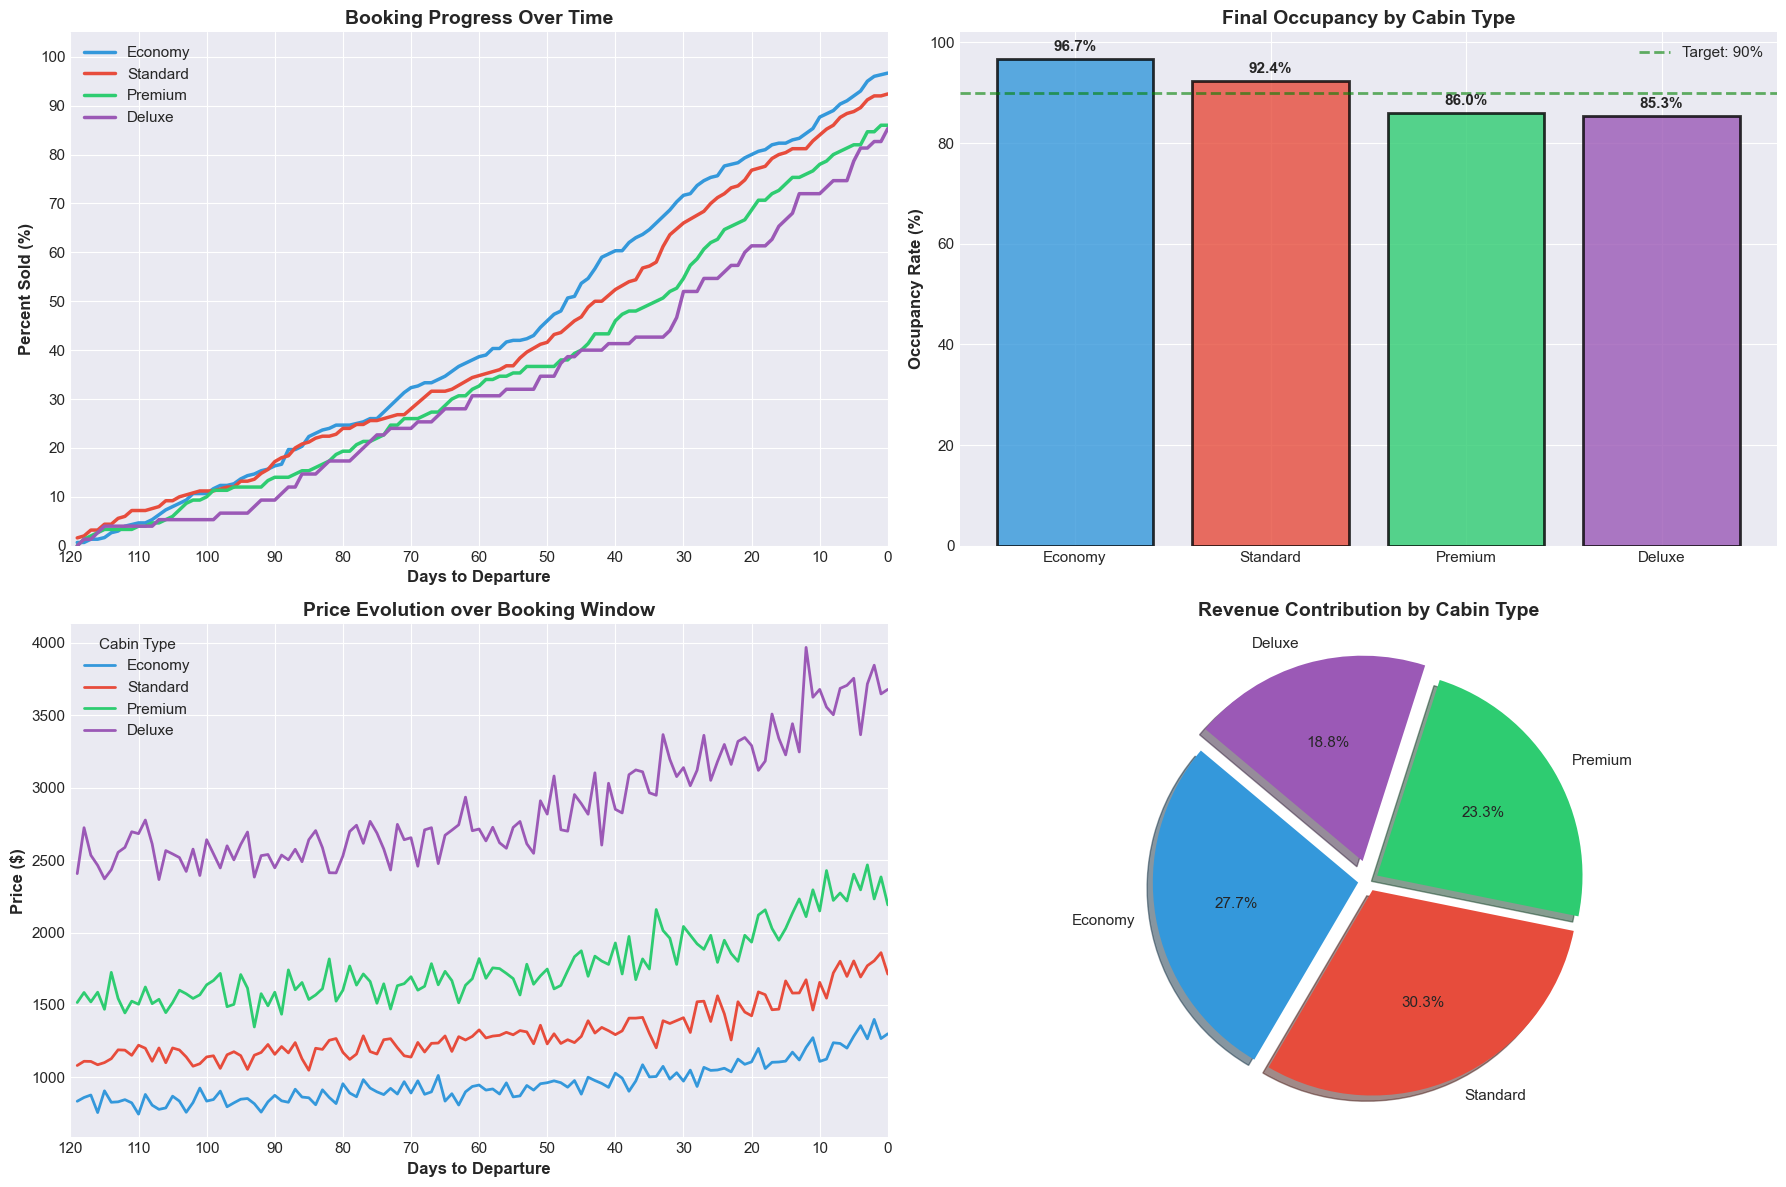

In [11]:
# --- Visualization Dashboard ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
colors = {'Economy': '#3498db', 'Standard': '#e74c3c', 'Premium': '#2ecc71', 'Deluxe': '#9b59b6'}
# Consistent font settings
title_font = {'fontsize': 14, 'fontweight': 'bold'}
label_font = {'fontsize': 12, 'fontweight': 'bold'}

# 1. Booking Progress (Top Left)
ax1 = axes[0, 0]
for cabin in ['Economy', 'Standard', 'Premium', 'Deluxe']:
    cabin_data = df[df['cabin_type'] == cabin].sort_values('date')
    percent_sold = (cabin_data['bookings'].cumsum() / cabin_data['total_inventory'].iloc[0] * 100)
    ax1.plot(cabin_data['days_to_departure'], percent_sold, label=cabin, linewidth=2.5, color=colors[cabin])
ax1.set_xlabel('Days to Departure', **label_font)
ax1.set_ylabel('Percent Sold (%)', **label_font)
ax1.set_title('Booking Progress Over Time', **title_font)
ax1.legend()
ax1.invert_xaxis()
ax1.set_xticks(range(120, -1, -10))
ax1.set_yticks(range(0, 102, 10))
ax1.set_ylim(0, 105)
ax1.set_xlim(120, 0)

# 2. Final Occupancy (Top Right)
ax2 = axes[0, 1]
occupancy_sorted = occupancy.sort_values('total_inventory', ascending=False)
bars = ax2.bar(occupancy_sorted.index, occupancy_sorted['occupancy_pct'], 
               color=[colors[c] for c in occupancy_sorted.index], alpha=0.8, edgecolor='black', linewidth=2)
for bar in bars:
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, f'{bar.get_height():.1f}%', 
             ha='center', va='bottom', fontweight='bold')
ax2.axhline(y=90, color='green', linestyle='--', linewidth=2, alpha=0.6, label='Target: 90%')
ax2.set_ylabel('Occupancy Rate (%)', **label_font)
ax2.set_title('Final Occupancy by Cabin Type', **title_font)
ax2.set_ylim(0, 102)
ax2.legend()

# 3. Option A: Price Evolution (Bottom Left)
ax3 = axes[1, 0]
for cabin in ['Economy', 'Standard', 'Premium', 'Deluxe']:
    cabin_data = df[df['cabin_type'] == cabin].sort_values('days_to_departure', ascending=False)
    ax3.plot(cabin_data['days_to_departure'], cabin_data['price'], label=cabin, linewidth=2, color=colors[cabin])
ax3.set_xlabel('Days to Departure', **label_font)
ax3.set_ylabel('Price ($)', **label_font)
ax3.set_title('Price Evolution over Booking Window', **title_font)
ax3.legend(title='Cabin Type')
ax3.invert_xaxis()
ax3.set_xticks(range(120, -1, -10))
ax3.set_xlim(120, 0)

# 4. Option B: Revenue Contribution (Bottom Right)
ax4 = axes[1, 1]
# Setting the subplot background to gray to match the consistent formatting
ax4.set_facecolor('#EAEAF2') 
revenue_dist = df.groupby('cabin_type')['revenue'].sum().reindex(['Economy', 'Standard', 'Premium', 'Deluxe'])
ax4.pie(revenue_dist, labels=revenue_dist.index, autopct='%1.1f%%', startangle=140, 
        colors=[colors[c] for c in revenue_dist.index], explode=(0.05, 0.05, 0.05, 0.1), shadow=True)
ax4.set_title('Revenue Contribution by Cabin Type', **title_font)

plt.tight_layout()
plt.show()

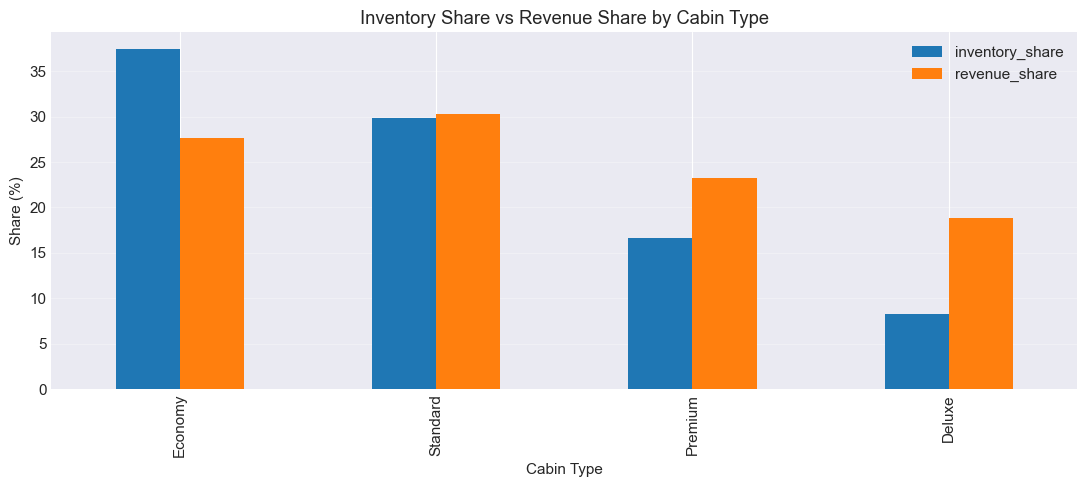

In [19]:
inventory_order = (
    df.groupby("cabin_type")["total_inventory"]
      .first()         
      .sort_values(ascending=False)
      .index
)
comparison_pct = comparison.copy()
comparison_pct[["inventory_share", "revenue_share"]] *= 100

comparison_pct[["inventory_share", "revenue_share"]].plot(
    kind="bar",
    figsize=(11, 5)
)

plt.ylabel("Share (%)")
plt.xlabel("Cabin Type")
plt.title("Inventory Share vs Revenue Share by Cabin Type")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()